In [1]:
# import findspark
# findspark.init()

# import sys
# from random import random
# from operator import add

# from pyspark.sql import SparkSession


# if __name__ == "__main__":
#     """
#         Usage: pi [partitions]
#     """
#     spark = SparkSession\
#         .builder\
#         .appName("PythonPi")\
#         .getOrCreate()

#     partitions = 2 # int(sys.argv[1]) if len(sys.argv) > 1 else 2
#     n = 100000 * partitions

#     def f(_):
#         x = random() * 2 - 1
#         y = random() * 2 - 1
#         return 1 if x ** 2 + y ** 2 <= 1 else 0

#     count = spark.sparkContext.parallelize(range(1, n + 1), partitions).map(f).reduce(add)
#     print("Pi is roughly %f" % (4.0 * count / n))

# spark.stop()

In [2]:
sc # automatically loaded

<SparkContext master=local[4] appName=PySparkShell>

Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pyspark.sql import SparkSession
import pyspark

# spark = pyspark.SQLContext(sc)
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

spark

Parsing (as `.csv` with ";" separator and a header)

We get spark DataFrame after the parsing (not RDD)

In [5]:
from pyspark.sql.types import *
b_sch = StructType([
    StructField('ISBN', StringType(), False),
    StructField('bookTitle', StringType(), False),
    StructField('bookAuthor', StringType(), False),
    StructField('yearOfPublication', StringType(), False),
    StructField('publisher', StringType(), False),
    StructField('imageUrlS', StringType(), True),
    StructField('imageUrlM', StringType(), True),
    StructField('imageUrlL', StringType(), True)
])
books_url = "./BX-Books.csv"
books_df = spark.read.csv(books_url, sep=";", header=True, schema=b_sch)

u_sch = StructType([
    StructField('userID', StringType(), False),
    StructField('Location', StringType(), False),
    StructField('Age', DoubleType(), False)
])
users_url = "./BX-Users.csv"
users_df = spark.read.csv(users_url, sep=";", header=True, schema=u_sch)

r_sch = StructType([
    StructField('userID', StringType(), False),
    StructField('ISBN', StringType(), False),
    StructField('bookRating', IntegerType(), True)
])
ratings_url = "./BX-Book-Ratings.csv"
# ratings_df = spark.read.load(ratings_url, sep=";", format='com.databricks.spark.csv', header=True, inferSchema=True)
ratings_df = spark.read.csv(ratings_url, sep=";", header=True, schema=r_sch)

print("Sizes")
print("Books count: " + str(books_df.count()))
print("Users count: " + str(users_df.count()))
print("Ratings count: " + str(ratings_df.count()))

books_df.printSchema()
users_df.printSchema()
ratings_df.printSchema()

Sizes
Books count: 271379
Users count: 278859
Ratings count: 1149780
root
 |-- ISBN: string (nullable = true)
 |-- bookTitle: string (nullable = true)
 |-- bookAuthor: string (nullable = true)
 |-- yearOfPublication: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- imageUrlS: string (nullable = true)
 |-- imageUrlM: string (nullable = true)
 |-- imageUrlL: string (nullable = true)

root
 |-- userID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Age: double (nullable = true)

root
 |-- userID: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- bookRating: integer (nullable = true)



## Rating distribution ##

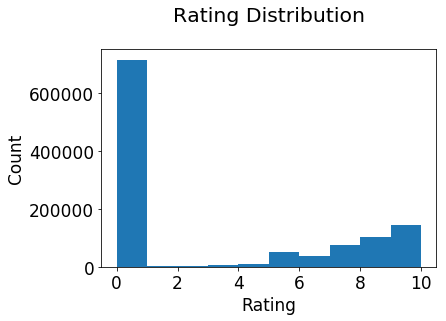

In [6]:
rt_bins, rt_weights = ratings_df.select('bookRating').rdd.flatMap(lambda x: x).histogram(10)
plt.rc("font", size=17)
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.hist(rt_bins[:-1], bins=rt_bins, weights=rt_weights)
plt.show()

## Age distribution ##

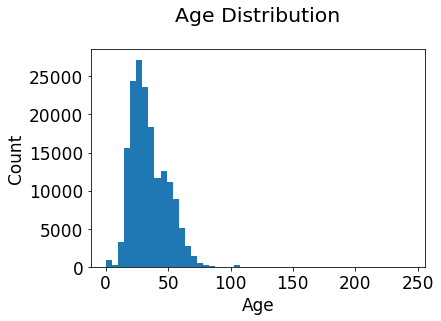

In [7]:
u_bins, u_weights = users_df.select('Age').rdd.flatMap(lambda x: x).histogram(50)
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.hist(u_bins[:-1], bins=u_bins, weights=u_weights)
plt.show()

## Average rating per book

In [8]:
import pyspark.sql.functions as pyspf

avg_ratings = ratings_df.groupby('ISBN').agg(pyspf.mean('bookRating').alias('bookRatingAvg'), pyspf.count('ISBN').alias('ratingCount'))
avg_ratings = avg_ratings.sort(pyspf.col('ratingCount').desc())
avg_ratings.limit(7).toPandas()

,ISBN,bookRatingAvg,ratingCount
0,0971880107,1.019584,2502
1,0316666343,4.468726,1295
2,0385504209,4.652322,883
3,0060928336,3.448087,732
4,0312195516,4.334716,723
5,044023722X,3.187017,647
6,0679781587,4.381847,639


## For the sake of statistics ##

Remove users who rated less than 200 books.

Remove books with less than 100 ratings in total.

In [9]:
ratings = ratings_df

from pyspark.sql.functions import col

counts1 = ratings.groupby('userID').count()
good_user =  counts1.where(col('count') >= 200)
ratings = ratings.where(col('userID').isin(good_user.select("userID").rdd.flatMap(lambda x: x).collect()))

counts2 = ratings.groupby('ISBN').count()
good_book =  counts2.where(col('count') >= 100)
ratings = ratings.where(col('ISBN').isin(good_book.select("ISBN").rdd.flatMap(lambda x: x).collect()))

print(ratings.count(), len(ratings.columns))

13793 3


In [10]:
ratings.limit(5).toPandas()

,userID,ISBN,bookRating
0,277427,0060930535,0
1,277427,0060934417,0
2,277427,0061009059,9
3,277427,0142001740,0
4,277427,0312966091,0


In [11]:
ratings_pivot = ratings.groupby('userID').pivot('ISBN').min('bookRating')
print(ratings_pivot.count(), len(ratings_pivot.columns))

ratings_pivot.limit(5).toPandas()

857 101


,userID,0060502258,0060928336,0060930535,0060934417,0060976845,0060987103,0061009059,006101351X,014028009X,...,067976402X,0679781587,068484477X,0743418174,0786868716,080410526X,0804106304,080410753X,0971880107,1400034779
0,32773,None,0.0,NaN,NaN,None,0.0,NaN,NaN,0.0,...,NaN,None,None,NaN,None,0.0,0.0,NaN,0.0,None
1,230249,None,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,...,NaN,None,None,NaN,None,0.0,NaN,NaN,0.0,None
2,227447,None,0.0,NaN,0.0,None,0.0,0.0,0.0,NaN,...,0.0,None,None,0.0,None,NaN,0.0,0.0,0.0,None
3,104665,None,0.0,NaN,NaN,None,NaN,6.0,NaN,NaN,...,NaN,None,None,NaN,None,NaN,NaN,NaN,NaN,None
4,131046,None,0.0,0.0,NaN,None,NaN,NaN,NaN,NaN,...,NaN,None,None,NaN,None,NaN,0.0,NaN,NaN,None


## Correlation-based recommendations

In [38]:
all_books = ratings_pivot.columns[1:]
counter = 0
correlation = {}
for book_i in all_books:
    correlation.setdefault(book_i, {})

In [47]:
import time

In [ ]:
counter = 0
start_time = time.time()
for book_i in all_books:
    for book_j in all_books:
        counter += 1
        if counter % 10 == 0:
            print("Iteration #", counter)
            pass
        if book_i is not book_j:
            correlation[book_i][book_j] = ratings_pivot.stat.corr(book_i, book_j)
            pass
end_time = time.time()
elapsed = start_time - end_time

print("It took ", elapsed/60, " minutes and ", elapsed%60, " seconds to calculate correlation")

Iteration # 10
Iteration # 20
Iteration # 30
Iteration # 40
Iteration # 50
Iteration # 60
Iteration # 70
Iteration # 80
Iteration # 90
Iteration # 100
Iteration # 110
Iteration # 120
Iteration # 130
Iteration # 140
Iteration # 150
Iteration # 160
Iteration # 170
Iteration # 180
Iteration # 190
Iteration # 200
Iteration # 210
Iteration # 220
Iteration # 230
Iteration # 240
Iteration # 250
Iteration # 260
Iteration # 270
Iteration # 280
Iteration # 290
Iteration # 300
Iteration # 310
Iteration # 320
Iteration # 330
Iteration # 340
Iteration # 350
Iteration # 360
Iteration # 370
Iteration # 380
Iteration # 390
Iteration # 400
Iteration # 410
Iteration # 420
Iteration # 430
Iteration # 440
Iteration # 450
Iteration # 460
Iteration # 470
Iteration # 480
Iteration # 490
Iteration # 500
Iteration # 510
Iteration # 520
Iteration # 530
Iteration # 540
Iteration # 550
Iteration # 560
Iteration # 570
Iteration # 580
Iteration # 590
Iteration # 600
Iteration # 610
Iteration # 620
Iteration # 630
I